# LEGO ETL - Staging

## Define functions

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def NullVisualise(df:pd.DataFrame):
    """
    NullVisualise(df) shows the the ratio if null values and fact values for each property as stack bar

    INPUT
    df: dataframe - a dataset in Pandas dataframe format
    
    """
    notNa = df.count()
    maxVal = df.shape[0]
    fig, ax = plt.subplots(figsize=(10, df.shape[1]/3))
    nnbars = ax.barh(notNa.index,notNa.values, label='Not Null', left=(maxVal-notNa.values), height= 0.8)
    nbars = ax.barh(notNa.index, maxVal-notNa.values, label='Null', left=0, height= 0.8)
    ax.bar_label(nnbars, label_type='center', color='white')
    ax.bar_label(nbars, label_type='center', color='white')
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, maxVal)
    ax.set_ylim(-1,df.shape[1])
    plt.xticks(rotation=90)
    ax.legend(ncols=len(notNa.index), bbox_to_anchor=(0, 1),
                loc='lower left', fontsize='small')
    plt.show()

def LegoSetCleaner(df:pd.DataFrame):
    """
    LegoSetCleaner(df) clean all the dataset

    INPUT
    path: string - Path to the CSV file from brickset.com

    OUTPUT
    cleaned_dataframe: Pandas Dataframe

    ERRORS
    -1: can't be able to trasform columns Number and Variant into strings
    
    """
    ## First, only keep sets that are released 
    lego_released = df[df['Released'].notna()]

    ## Then delete the columns that do not serve our purposes
    lego_released.drop(['SetID', 'Image', 'ImageFilename', 'USDateAdded', 'USDateRemoved','USItemNumber','EUItemNumber', 'EAN', 'UPC',\
                        'Width', 'Height', 'Depth', 'Weight',\
                        'UKRetailPrice', 'CARetailPrice', 'DERetailPrice',\
                        'OwnCount', 'WantCount', 'InstructionsCount', 'AdditionalImageCount',\
                        'Released', 'Designers', 'LaunchDate', 'ExitDate'], axis=1, inplace=True)
    
    ## Let's try transforming the columns Number and Variant into strings
    try:
        lego_released[['Number', 'Variant']] = lego_released[['Number', 'Variant']].astype(str)
    except Exception as e:
        print(f'Exception: {e} | cannot trasform columns Number and Variant into strings')
        return e
    
    ## Reconstruct the set ID in standard LEGO-format from columns Number and Variant 
    lego_released['SetID'] = lego_released[['Number', 'Variant']].agg('-'.join, axis=1)

    ## Keep the building sets and eliminate books, gadgets and other related products
    lego_released_sets = lego_released[lego_released['Category'].isin(['Normal', 'Collection'])]   

    ## Create a mixed price column by replacing the missing prices with those from the stock market, if present
    # -- Not sure this is useful 
    
    contidions = [(lego_released_sets['USRetailPrice'].notna()),\
              (lego_released_sets['USRetailPrice'].isna() & lego_released_sets['BrickLinkSoldPriceNew'].notna()),\
              (lego_released_sets['USRetailPrice'].isna() & lego_released_sets['BrickLinkSoldPriceNew'].isna() ) ]

    values = [lego_released_sets['USRetailPrice'], lego_released_sets['BrickLinkSoldPriceNew'], np.nan]

    lego_released_sets['MixedPrice'] = np.select(contidions, values)
    
    ## Create the price per piece and the stock market price per piece
    #lego_released_sets['PricePerPiece'] = lego_released_sets['USRetailPrice'] / lego_released_sets['Pieces']
    #lego_released_sets['StockMarketPerPiece'] = lego_released_sets['BrickLinkSoldPriceNew'] / lego_released_sets['Pieces']

    return lego_released_sets


## Create the source dataset
### Iterate over *csv* files in the data folder to create the source dataset

Files are downloaded from [BRICKSET](https://brickset.com/sets)  
If you want to change directory please edit `folder = os.fsencode('.')` at line 5

In [4]:
import os
import warnings
warnings.filterwarnings('ignore')

folder = os.fsencode('.')
lego_dataset = pd.DataFrame()

for file in os.listdir(folder):
    filename = os.fsdecode(file)
    if filename.endswith(".csv"): 
        print(f'Working on {filename}')
        lego_set = pd.read_csv(filename)
        lego_dataset = pd.concat([lego_dataset, lego_set], ignore_index=True)
        print(f'LEGO Dataset shape {lego_dataset.shape}')
        print('-*'*10)
    else:
        continue

Working on Brickset-list1970.csv
LEGO Dataset shape (41, 42)
-*-*-*-*-*-*-*-*-*-*
Working on Brickset-list1971.csv
LEGO Dataset shape (119, 42)
-*-*-*-*-*-*-*-*-*-*
Working on Brickset-list1972.csv
LEGO Dataset shape (164, 42)
-*-*-*-*-*-*-*-*-*-*
Working on Brickset-list1973.csv
LEGO Dataset shape (240, 42)
-*-*-*-*-*-*-*-*-*-*
Working on Brickset-list1974.csv
LEGO Dataset shape (280, 42)
-*-*-*-*-*-*-*-*-*-*
Working on Brickset-list1975.csv
LEGO Dataset shape (325, 42)
-*-*-*-*-*-*-*-*-*-*
Working on Brickset-list1976.csv
LEGO Dataset shape (401, 42)
-*-*-*-*-*-*-*-*-*-*
Working on Brickset-list1977.csv
LEGO Dataset shape (475, 42)
-*-*-*-*-*-*-*-*-*-*
Working on Brickset-list1978.csv
LEGO Dataset shape (562, 42)
-*-*-*-*-*-*-*-*-*-*
Working on Brickset-list1979.csv
LEGO Dataset shape (652, 42)
-*-*-*-*-*-*-*-*-*-*
Working on Brickset-list1980.csv
LEGO Dataset shape (769, 42)
-*-*-*-*-*-*-*-*-*-*
Working on Brickset-list1981.csv
LEGO Dataset shape (844, 42)
-*-*-*-*-*-*-*-*-*-*
Worki

### Save source file

In [5]:
if not os.path.exists('source'):
    os.makedirs('source')
lego_dataset.to_csv(f'source{os.sep}lego.csv')

### Check for null values over properties

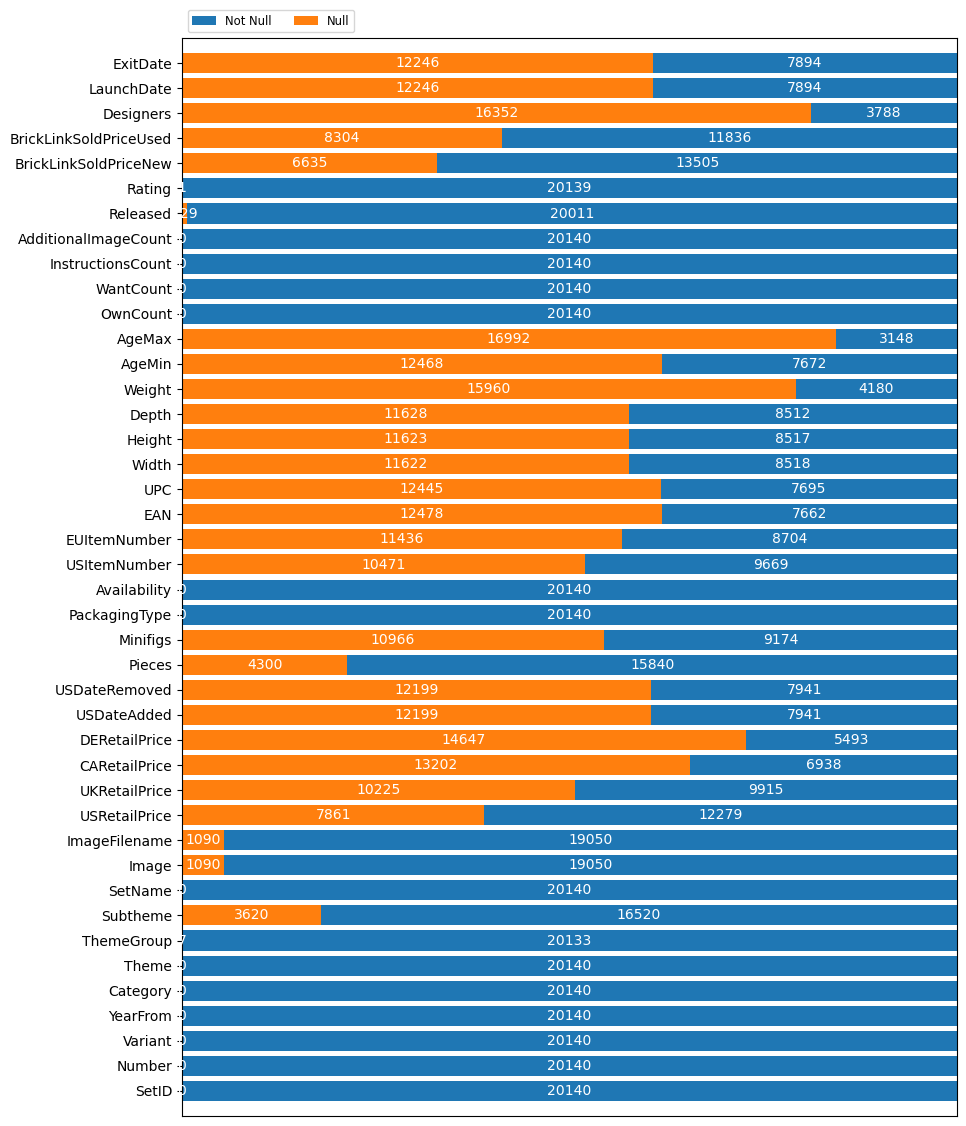

In [12]:
NullVisualise(lego_dataset)

## Start the data manipulation to obtain stage dataset
### Apply the cleaning function

In [27]:
lego_cleaned_dataset = LegoSetCleaner(lego_dataset)
lego_cleaned_dataset.shape

(14288, 20)

### Find Null values in  properties

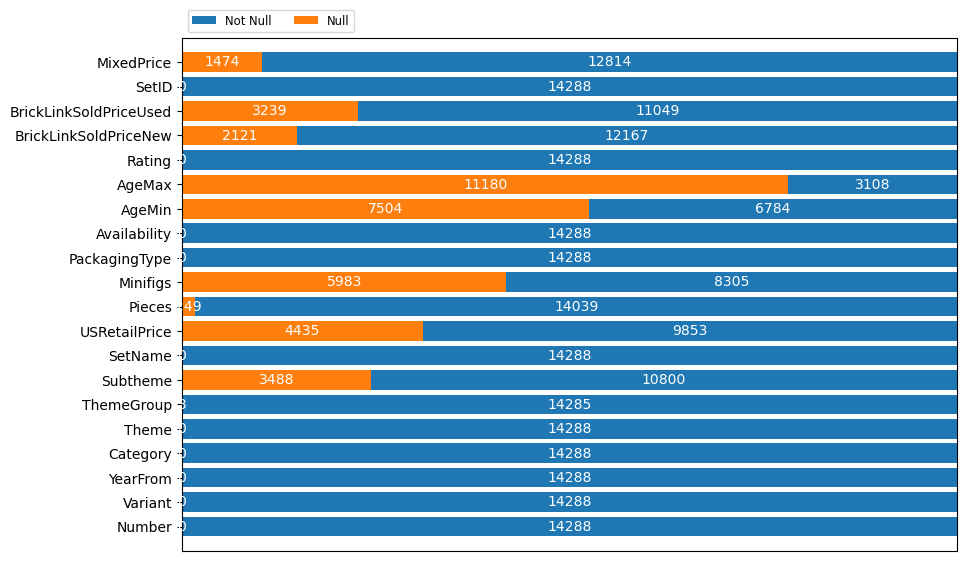

In [14]:
NullVisualise(lego_cleaned_dataset)

### Some other stats

In [15]:
lego_cleaned_dataset.describe()

,YearFrom,USRetailPrice,Pieces,Minifigs,AgeMin,AgeMax,Rating,BrickLinkSoldPriceNew,BrickLinkSoldPriceUsed,MixedPrice
count,14288.000000,9853.000000,14039.000000,8305.000000,6784.000000,3108.000000,14288.000000,12167.000000,11049.000000,12814.000000
mean,2007.052772,36.053014,262.509367,2.775196,6.899912,13.053732,11.373250,101.826454,44.249564,55.411796
std,13.023484,53.861869,505.019665,2.922969,3.106091,10.323540,22.967069,273.329611,83.169521,192.761333
min,1970.000000,0.000000,0.000000,1.000000,1.000000,3.000000,0.000000,0.030000,0.010000,0.000000
25%,1999.000000,7.990000,28.000000,1.000000,5.000000,12.000000,0.000000,14.505000,7.680000,8.000000
50%,2010.000000,19.990000,92.000000,2.000000,6.000000,12.000000,4.000000,36.770000,18.670000,19.990000
75%,2018.000000,40.000000,296.000000,3.000000,8.000000,14.000000,13.000000,94.920000,47.590000,49.990000
max,2024.000000,849.990000,11695.000000,80.000000,18.000000,99.000000,415.000000,9296.860000,3438.450000,9000.000000


### Check and remove duplicates

In [16]:
# Check fot duplicated in SetID
lego_cleaned_dataset[lego_cleaned_dataset.duplicated(subset=['SetID'])]

,Number,Variant,YearFrom,Category,Theme,ThemeGroup,Subtheme,SetName,USRetailPrice,Pieces,Minifigs,PackagingType,Availability,AgeMin,AgeMax,Rating,BrickLinkSoldPriceNew,BrickLinkSoldPriceUsed,SetID,MixedPrice
562,11,2,1979,Normal,Town,Modern day,Accessories,Town Minifigures,4.49,3.0,3.0,Blister pack,Retail - limited,NaN,NaN,0.0,NaN,5.01,11-2,4.49
844,14,1,1982,Normal,Space,Action/Adventure,Classic,Space Mini-Figures,NaN,24.0,4.0,{Not specified},{Not specified},NaN,NaN,0.0,NaN,NaN,14-1,NaN
994,15,1,1984,Normal,Castle,Historical,Classic,Castle Minifigures,NaN,10.0,6.0,{Not specified},{Not specified},NaN,NaN,0.0,NaN,62.63,15-1,NaN


In [17]:
# drop duplicated SetID (no need to keep them)
lego_cleaned_dataset = lego_cleaned_dataset[~lego_cleaned_dataset['SetID'].isin(['15-1', '14-1', '11-2'])]
lego_cleaned_dataset.shape

(14282, 20)

### Remove rows with missing values for `MixedPrice`

In [29]:
# remove rows with missing values for mixed price. imputation is possible as a future development after understanding the data better
lego_cleaned_dataset = lego_cleaned_dataset[~lego_cleaned_dataset['MixedPrice'].isna()]
lego_cleaned_dataset.shape

(12814, 20)

### Set minumin age to `18` for missing values in `AgeMin`
There could be several choices, in this case we decided to be conservative with respect to the construction difficulties.

In [19]:
#set minumin age to 1 for missing values
lego_cleaned_dataset.loc[lego_cleaned_dataset['AgeMin'].isna(), 'AgeMin'] = 18

### Set value to `0` for missing values in `Minifigs`

In [20]:
# Set `0` for missing values in `Minifigs`
lego_cleaned_dataset.loc[lego_cleaned_dataset['Minifigs'].isna(), 'Minifigs'] = 0

### Check the quality (null values)

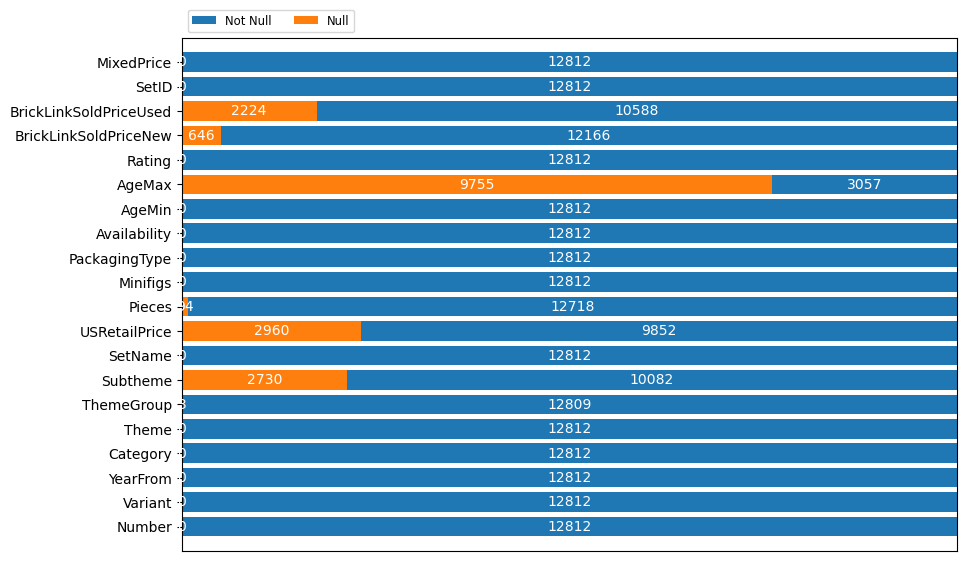

In [21]:
NullVisualise(lego_cleaned_dataset)

### List the unique values for `Category`, `ThemeGroup`, `Theme` and `Subtheme`

In [22]:
lego_cleaned_dataset['Category'].unique()

array(['Normal', 'Collection'], dtype=object)

In [23]:
lego_cleaned_dataset['ThemeGroup'].unique()

array(['Vintage', 'Modern day', 'Pre-school', 'Basic', 'Educational',
       'Technical', 'Miscellaneous', 'Historical', 'Action/Adventure',
       'Junior', 'Girls', 'Model making', 'Racing', 'Licensed',
       'Constraction', nan, 'Art and crafts'], dtype=object)

In [24]:
lego_cleaned_dataset['Theme'].unique()

array(['Samsonite', 'Trains', 'Duplo', 'LEGOLAND',
       'Universal Building Set', 'Minitalia', 'Basic', 'Dacta',
       'Homemaker', 'Building Set with People', 'Hobby Set', 'Technic',
       'Service Packs', 'Town', 'Castle', 'Space', 'Fabuland', 'Scala',
       'Boats', 'Model Team', 'Assorted', 'Pirates', 'Promotional',
       'Belville', 'Aquazone', 'Freestyle', 'Time Cruisers', 'Western',
       'Education', 'Primo', 'Classic', 'Adventurers', 'Znap', 'Racers',
       'Mindstorms', 'Seasonal', 'Rock Raiders', 'Star Wars', 'Studios',
       'Baby', 'Action Wheelers', 'Sports', 'Bulk Bricks',
       'Advanced models', 'Mickey Mouse', 'Bionicle', 'Creator',
       'Jack Stone', 'Harry Potter', 'Dinosaurs', 'Alpha Team', 'Explore',
       'Spybotics', 'Galidor', 'Island Xtreme Stunts', 'Clikits',
       'World City', '4 Juniors', 'Spider-Man', 'Discovery', 'Quatro',
       'Make and Create', 'City', 'Factory', 'Vikings', 'Dino 2010',
       'Dino Attack', 'SpongeBob SquarePants',
   

In [25]:
lego_cleaned_dataset['Subtheme'].unique()

array(['Supplemental', 'Supplemental / 4.5V', '4.5v', 'Model Maker',
       'Basic Set', 'Vehicle', 'Supplemental / 12V', '12V', 'Gears',
       'Basic set', nan, 'Building', '4.5/12V', 'Jumbo Bricks', 'Town',
       'Boats', 'Supplementaries', 'Model', 'Seasonal', 'Supplementary',
       'Trains', 'Accessories', 'Classic', 'Technic', 'Jewellery',
       'Educational', 'Special', 'Shops and Services', 'Medical',
       'Racing', 'Vehicles', 'Maintenance', 'Construction', 'Fire',
       'Leisure', 'Police', 'Space', 'Postal', 'Universal',
       'Bonus/Value Pack', 'Baby', 'Product Collection', 'Lion Knights',
       'Black Falcons', 'Universal Building Set', 'Flight', 'Emergency',
       'Arctic', 'Duplo', 'Forestmen', 'Futuron', 'Blacktron',
       'Black Knights', 'Miscellaneous', 'Monorail', 'Castle',
       'Imperial Guards', 'Coastguard', 'Rescue', 'Space Police',
       'Stunt Club', 'Ferries', 'Pirates', 'M-Tron', 'Storage',
       'Blacktron 2', '9V', 'Toolo', 'Wolfpack', 'Para

## Save staging files

In [26]:
if not os.path.exists('staging'):
    os.makedirs('staging')
lego_cleaned_dataset.to_csv(f'staging{os.sep}lego.csv')